

---Image-to-Image task is the task where an application receives an image and outputs another image. This has various subtasks, including image enhancement (super resolution, low light enhancement, deraining and so on), image inpainting, and more.

This guide will show you how to:

Use an image-to-image pipeline for super resolution task,
Run image-to-image models for same task without a pipeline.

Note that as of the time this guide is released, image-to-image pipeline only supports super resolution task.

Let’s begin by installing the necessary libraries.



In [ ]:
!pip install transformers

We can now initialize the pipeline with a Swin2SR model. We can then infer with the pipeline by calling it with an image. As of now, only Swin2SR models are supported in this pipeline.

In [4]:
import torch


In [5]:
from transformers import pipeline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipeline(task="image-to-image", model="caidas/swin2SR-lightweight-x2-64", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

Now, let’s load an image.

In [6]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/cat.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print(image.size)

(532, 432)


Now, let’s load an image.

In [7]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/cat.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print(image.size)

(532, 432)


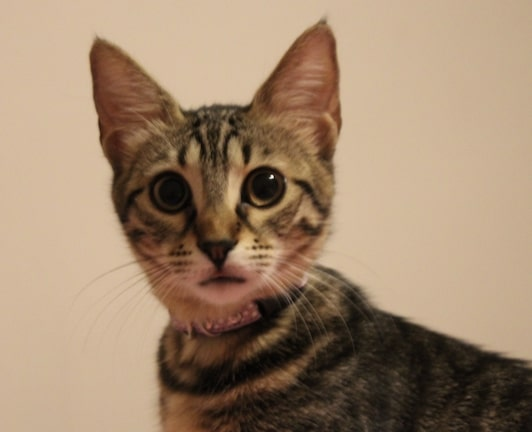

In [8]:
image

We can now do inference with the pipeline. We will get an upscaled version of the cat image.

In [9]:
upscaled = pipe(image)
print(upscaled.size)

(1072, 880)


If you wish to do inference yourself with no pipeline, you can use the Swin2SRForImageSuperResolution and Swin2SRImageProcessor classes of transformers. We will use the same model checkpoint for this. Let’s initialize the model and the processor.

In [10]:
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor

model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64").to(device)
processor = Swin2SRImageProcessor("caidas/swin2SR-lightweight-x2-64")

pipeline abstracts away the preprocessing and postprocessing steps that we have to do ourselves, so let’s preprocess the image. We will pass the image to the processor and then move the pixel values to GPU.

In [11]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

pixel_values = pixel_values.to(device)

torch.Size([1, 3, 440, 536])


We can now infer the image by passing pixel values to the model.

In [12]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

Output is an object of type ImageSuperResolutionOutput that looks like below 👇

In [ ]:
(loss=None, reconstruction=tensor([[[[0.8270, 0.8269, 0.8275,  ..., 0.7463, 0.7446, 0.7453],
          [0.8287, 0.8278, 0.8283,  ..., 0.7451, 0.7448, 0.7457],
          [0.8280, 0.8273, 0.8269,  ..., 0.7447, 0.7446, 0.7452],
          ...,
          [0.5923, 0.5933, 0.5924,  ..., 0.0697, 0.0695, 0.0706],
          [0.5926, 0.5932, 0.5926,  ..., 0.0673, 0.0687, 0.0705],
          [0.5927, 0.5914, 0.5922,  ..., 0.0664, 0.0694, 0.0718]]]],
       device='cuda:0'), hidden_states=None, attentions=None)

We need to get the reconstruction and post-process it for visualization. Let’s see how it looks like.

In [13]:
outputs.reconstruction.data.shape
# torch.Size([1, 3, 880, 1072])

torch.Size([1, 3, 880, 1072])

We need to squeeze the output and get rid of axis 0, clip the values, then convert it to be numpy float. Then we will arrange axes to have the shape [1072, 880], and finally, bring the output back to range [0, 255].

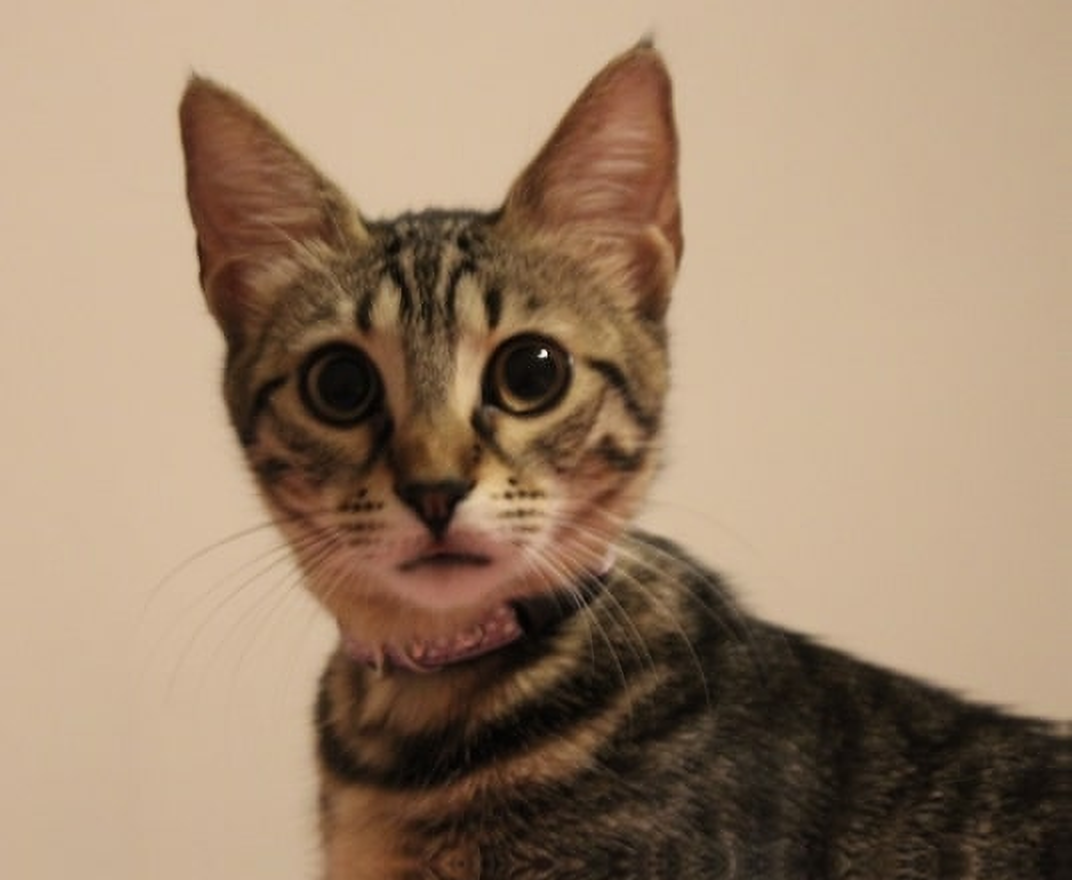

In [14]:
import numpy as np

# squeeze, take to CPU and clip the values
output = outputs.reconstruction.data.squeeze().cpu().clamp_(0, 1).numpy()
# rearrange the axes
output = np.moveaxis(output, source=0, destination=-1)
# bring values back to pixel values range
output = (output * 255.0).round().astype(np.uint8)
Image.fromarray(output)